# Laboratory practice № 4 (astatisms)

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 16

## Preparation

In [1]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np

In [2]:
dt = 0.001

## Task 1 (Stabilization with ideal differentiator)

In [3]:
a_1 = sympy.Symbol("a_1")
a_0 = sympy.Symbol("a_0")
sympy.solve([-1 + 2 + a_1,-1 * 2 -a_0],a_1,a_0)

{a_0: -2, a_1: -1}

In [4]:
a_1 = sympy.Symbol("a_1")
a_0 = sympy.Symbol("a_0")
sympy.solve([-1  - 3 + a_1,-1 * (-3) -a_0],a_1,a_0)

{a_0: 3, a_1: 4}

In [5]:
k_0 = -5
k_1 = -5

In [6]:
tf_sys_1 = ctrl.tf([1],[1,-1,-2])
tf_sys_1 

TransferFunction(array([1]), array([ 1, -1, -2]))

In [7]:
ss_sys_1, _ = ctrl.canonical_form(ctrl.tf2ss(tf_sys_1), form="reachable")

In [8]:
modeling_time_1 = 10 # sec
time_1 = np.linspace(0,modeling_time_1,int(modeling_time_1/dt))
init_state_1 = [1, 2]

In [9]:
ss_sys_1

StateSpace(array([[1., 2.],
       [1., 0.]]), array([[1.],
       [0.]]), array([[0., 1.]]), array([[0.]]))

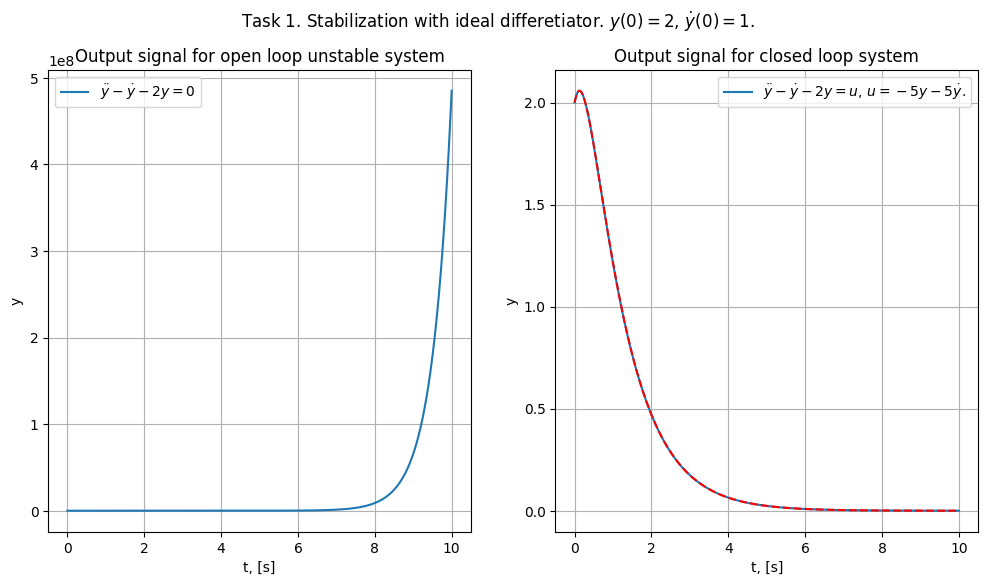

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
y_1_open = ctrl.initial_response(ss_sys_1,time_1,init_state_1).outputs
ax[0].plot(time_1,y_1_open,label="$\ddot y - \dot y - 2y=0$")

sys_state = init_state_1.copy()
y_1_closed = [sys_state[1]] * 2
for t_i in range(len(time_1)-1):
    u = k_0 * (y_1_closed[-1]) + k_1 * (y_1_closed[-1] - y_1_closed[-2])/dt
    res = ctrl.forced_response(ss_sys_1,time_1[t_i:t_i+2],u,sys_state)
    sys_state = res.states[:,-1].flatten().copy()
    y_1_closed.append(res.outputs[-1]) #+ (np.random.normal(0,0.01) if t_i % 10 == 0 else 0))
y_1_closed = y_1_closed[1:]
ax[1].plot(time_1,y_1_closed,label="$\ddot y - \dot y - 2y=u$, $u=-5y -5\dot y$.")
ax[1].plot(time_1, 3.5 * np.exp(-time_1) - 1.5 * np.exp(-3*time_1),"r--")

fig.suptitle(f"Task 1. Stabilization with ideal differetiator. $y(0) = 2$, $\dot y(0)=1$.")
ax[0].set_ylabel("y")
ax[0].set_xlabel("t, [s]")
ax[0].grid(True)
ax[0].set_title(f"Output signal for open loop unstable system")
ax[0].legend()

ax[1].set_ylabel("y")
ax[1].set_xlabel("t, [s]")
ax[1].grid(True)
ax[1].set_title(f"Output signal for closed loop system")
ax[1].legend()

## Task 2 (Stabilization with real differentiator)

In [11]:
s, T = sympy.symbols("s T")

In [12]:
W = 1/(s**2-s -2) * (-5 - 5*s/(T*s+1))
W_f = W/(1-W)
W_f.simplify()

5*(-T*s - s - 1)/(5*T*s + 5*s - (T*s + 1)*(-s**2 + s + 2) + 5)

In [13]:
num, den = sympy.fraction(W_f.simplify())
den.expand(),"====", num.expand()

(T*s**3 - T*s**2 + 3*T*s + s**2 + 4*s + 3, '====', -5*T*s - 5*s - 5)

In [14]:
T_vals = [0.1, 0.05, 0.0001]

In [15]:
num_coeffs = []
denom_coeffs = []
for T_val in T_vals:
    num_coeffs.append(list(map(float, sympy.Poly((num.expand()/T).subs(T,T_val),s).all_coeffs())))
    denom_coeffs.append(list(map(float, sympy.Poly((den.expand()/T).subs(T,T_val),s).all_coeffs())))

In [16]:
full_tfs_2  = [] 
for i in range(len(T_vals)):
    full_tfs_2.append(ctrl.tf(num_coeffs[i],denom_coeffs[i]))

In [17]:
def set_y_initials(ss, init):
    x_1, x_2, x_3 = sympy.symbols("x_1 x_2 x_3")
    sol = sympy.solve([
        ss.C[0][1]*x_2 + ss.C[0][2]*x_3 - init[0],
        ss.C[0][1]*x_1 + ss.C[0][2]*x_2 - init[1],
        ss.C[0][1]*(ss.A[0][0]*x_1+ss.A[0][1]*x_2+ss.A[0][2]*x_3) + ss.C[0][2]*x_1 - init[2]
    ])
    return list(map(float,[sol[x_1],sol[x_2],sol[x_3]]))

In [18]:
ss_sys = []
for i in range(len(T_vals)):
    ss_sys.append(ctrl.canonical_form(ctrl.tf2ss(full_tfs_2[i]),"reachable")[0])

In [19]:
modeling_time_2 = 10 # sec
time_2 = np.linspace(0,modeling_time_2,int(modeling_time_2/dt))
init_states_2 = []
for i in range(len(T_vals)):
    init_states_2.append(set_y_initials(ss_sys[i],[2,1,0]))

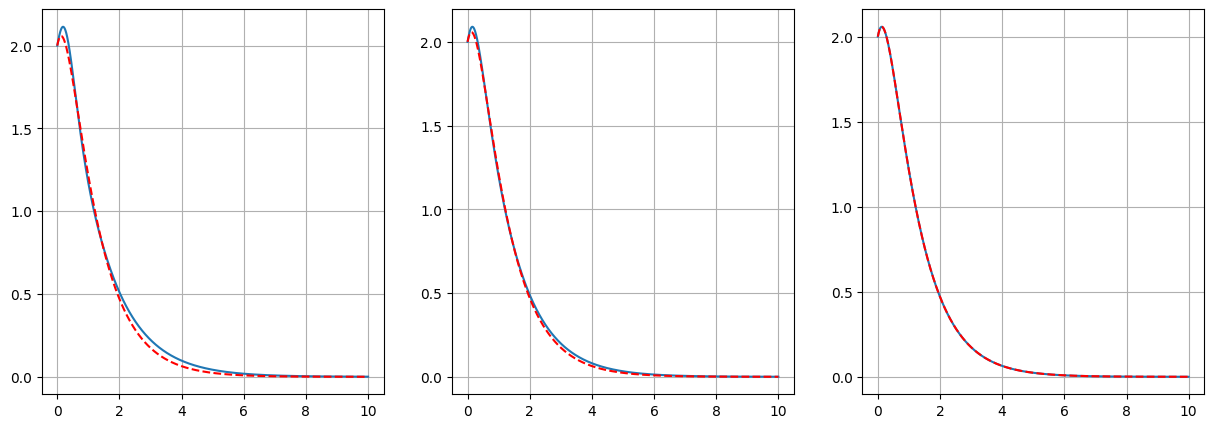

In [20]:
y_2_closed = []
y_2_closed.append(ctrl.initial_response(ss_sys[0],time_2,init_states_2[0]).outputs) 
y_2_closed.append(ctrl.initial_response(ss_sys[1],time_2,init_states_2[1]).outputs) 
y_2_closed.append(ctrl.initial_response(ss_sys[2],time_2,init_states_2[2]).outputs)  

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(T_vals)):
    ax[i].plot(time_2,y_2_closed[i])
    ax[i].plot(time_2, 3.5 * np.exp(-time_2) - 1.5 * np.exp(-3*time_2),"r--")
    ax[i].grid(True)


## Task 3 (Noise)

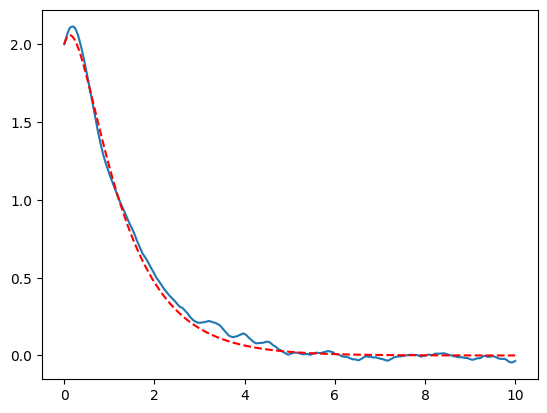

In [36]:
noise = np.zeros_like(time_2)
for i in range(len(time_2)// 10):
    noise[10*i] = np.random.normal(0,1)
plt.plot(time_2,ctrl.forced_response(ss_sys[0],time_2,noise,init_states_2[0]).outputs)
plt.plot(time_2, 3.5 * np.exp(-time_2) - 1.5 * np.exp(-3*time_2),"r--")

## Task 4 (0 astatism)

In [37]:
W_3 = (s + 1) / (s**2 - 5*s + 6)
W_3

(s + 1)/(s**2 - 5*s + 6)

In [88]:
k_0, k_1 = sympy.symbols("k_0 k_1")

In [89]:
W_reg = k_0 + k_1/s

In [90]:
W_f = W_3 * W_reg/(1+ W_reg*W_3)
W_f.simplify()

(s + 1)*(k_0*s + k_1)/(s*(s**2 - 5*s + 6) + (s + 1)*(k_0*s + k_1))

In [91]:
num, den = sympy.fraction(W_f.simplify())
den.expand(),"====", num.expand()

(k_0*s**2 + k_0*s + k_1*s + k_1 + s**3 - 5*s**2 + 6*s,
 '====',
 k_0*s**2 + k_0*s + k_1*s + k_1)

In [103]:
num_k = list(map(float, sympy.Poly((num.expand()).subs(k_0,8).subs(k_1,10),s).all_coeffs()))
denom_k = list(map(float, sympy.Poly((den.expand()).subs(k_0,8).subs(k_1,10),s).all_coeffs()))

In [104]:
tf_3 = ctrl.tf(num_k,denom_k)
tf_3

TransferFunction(array([ 8., 18., 10.]), array([ 1.,  3., 24., 10.]))

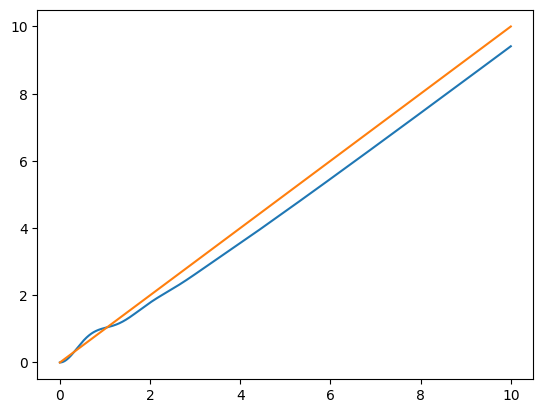

In [105]:
plt.plot(time_2,ctrl.forced_response(tf_3,time_2,time_2).outputs)
plt.plot(time_2, time_2)